In [1]:
import pandas as pd 
import numpy as np
import prepare , explore, modeling, evaluate
#to see the whole review, display max column width
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_palette("colorblind")
sns.set_style('darkgrid')

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Rate My Review
## An Analysis on Hotel reviews in Texas
#### Xavier Carter, September 2021

----

#### The Dataset
- Using Selinium, 13,800 reviews were gathered from various hotels across 4 major cities in Texas (Houston, Austin, Dallas, San Antonio)

#### Project Goals
- Analyze reviews to understand correlation to the review rating and the review. 
- Build a machine learning model to predict what rating a review should get.

#### Executive Summary
- Executive Summary here

----

## Acquire
- Utilizing Selinium (see acquire1.py and acquire2.py) , Gathering review information from TripAdvisor.com
- For sake of time, the max number of reviews looked at for each hotel was maxed to 35, as some hotels had hundreds of reviews

In [2]:
df = pd.read_csv('hotel_data.csv')

In [3]:
df.head(2)

hotel_name   hotel_city     date_of_stay  \
0  Drury Plaza Hotel San Antonio Riverwalk  San Antonio   September 2021   
1  Drury Plaza Hotel San Antonio Riverwalk  San Antonio   September 2020   

   review_rating  \
0              5   
1              5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  review  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Joseph was so helpful and attentive! Awesome customer service. Made our trip more enjoyable! This will now be our go to hotel when we come to San Antonio. Everything about the hotel was nice and the staff was very friendly. Very pleased with the whole experience.  
1  We stayed one night at the Drury Plaza Riverwalk in mid-September. Sooo enjoyed our stay. Definitely our favorite hotel on the Riverwalk. We specifically stayed here for the rooms with the balconies overlooking the San Fernando Cathedral. I sat on that balcony all day long, reading and enjoying the view, even despite the day of rain! Love the separate bedroom! The afternoon happy hour could have easily sufficed for dinner had the allure of the Riverwalk restaurants not been there. The indoor pool/hot tub was nice, and the fitness center was perfectly equipped with great views while running the treadmill. The breakfast was hearty and very good quality...love that they have biscuits and gravy! Every employee we encountered was upbeat and kind and seemed to be interested in serving

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13801 entries, 0 to 13800
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   hotel_name     13801 non-null  object
 1   hotel_city     13801 non-null  object
 2   date_of_stay   13801 non-null  object
 3   review_rating  13801 non-null  int64 
 4   review         13801 non-null  object
dtypes: int64(1), object(4)
memory usage: 539.2+ KB


In [5]:
df.isna().sum()

hotel_name       0
hotel_city       0
date_of_stay     0
review_rating    0
review           0
dtype: int64

In [6]:
df.describe()

review_rating
count   13801.000000
mean        3.622564
std         1.559053
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         5.000000

In [7]:
for i in df.columns:
    print(df[i].value_counts())
    print('---------------------------')

Fairmont Austin                                         70
La Cantera Resort & Spa                                 70
Courtyard Houston by The Galleria                       35
Hilton Garden Inn Austin Downtown/Convention Center     35
HYATT House Houston/Galleria                            35
                                                        ..
NATIONAL AT 2929 WYCLIFF                                 1
Hilton Garden Inn Austin University Capitol District     1
Mint House | The Hatchery                                1
TownePlace Suites Austin Northwest / The Domain Area     1
Palace Inn Beltway & Westview                            1
Name: hotel_name, Length: 548, dtype: int64
---------------------------
Austin         4033
San Antonio    3633
Houston        3574
Dallas         2561
Name: hotel_city, dtype: int64
---------------------------
 August 2021       1356
 July 2021         1215
 February 2020      696
 June 2021          696
 May 2021           695
                   .

#### Acquire Findings 

#### TO-Do's:
1). The cap for reviews was 35, each review being unique, since value counts of 70 and 2 were seen, duplicates exist in the data. duplicates need to be removed.

2). Month and year can be in their own seperate columns.

3.) no null values or missing values. 

4.) Standardize english words using NLP processing, Standard cleaning using NLTK.

----

## Prepare
- In Preperation, we will
     * Drop Duplicates
     * Split month and year into seperate columns 
     * Drop date of stay column
     * Prep review content (Basic cleaning, tokenizing, removing stop words, excluding common negative stop words)
     * Makeing columns for word and letter count
     * creating columns for negative , postive and neautral sentiment from cleaned version of the review (post clean, tokenize , lemmatized, and stop words removed, keeping popular negative stop words as negative stops words have the power to change the meaning of the review)
     * create bins for sentiment columns for exploration

In [8]:
df = prepare.prep_review_data(df)

In [9]:
df.head(3)

hotel_name   hotel_city  review_rating  \
0  Drury Plaza Hotel San Antonio Riverwalk  San Antonio              5   
1  Drury Plaza Hotel San Antonio Riverwalk  San Antonio              5   
2  Drury Plaza Hotel San Antonio Riverwalk  San Antonio              5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Joseph was so helpful and attentive! Awesome customer service. Made our trip more enjoyable! This will now be our go to hotel when we come to San Antonio. Everything about the hotel was nice and the staff was very friendly. Very pleased with the whole experience.   
1  We stayed one night at the Drury Plaza Riverwalk in mid-September. Sooo enjoyed our stay. Definitely our favorite hotel on the Riverwalk. We specifically stayed here for the rooms with the balconies overlooking the San Fernando Cathedral. I sat on that balcony all day long, reading and enjoying the view, even despite the day of rain! Love the separate bedroom! The afternoon happy hour could have easily sufficed for dinner had the allure of the Riverwalk restaurants not been there. The indoor pool/hot tub was nice, and the fitness center was perfectly equipped with great views while running the treadmill. The breakfast was hearty and very good quality...love that they have biscuits and gravy! Every employee we encountered was upbeat and kind and seemed to be interested in serving   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              On a very busy weekend, I had the pleasure of experiencing, Excellent customer service and very friendly Felt I made the right choice staying here Johnny and ZOE made me feel special And they were busy   

  month_of_stay  year_of_stay  \
0     September          2021   
1     September          2020   
2     September          2021   

                                                                                                                                                                                                                                                                                                                                                                                                                                 

----

## Outliers 
- Here , we'll take a look at possible anomolies
     * looking at positive sentiment reviews with low ratings
     * looking at negative sentiment reviews with high ratings

In [10]:
postive_when_neg  = (df.positive_sentiment  > df.negative_sentiment) & (df.review_rating < 3)
negative_when_pos = (df.negative_sentiment  > df.positive_sentiment) & (df.review_rating > 3)

In [11]:
df[postive_when_neg].head()

hotel_name   hotel_city  review_rating  \
27  Drury Plaza Hotel San Antonio Riverwalk  San Antonio              1   
51                 Hotel Valencia Riverwalk  San Antonio              2   
52                 Hotel Valencia Riverwalk  San Antonio              1   
53                 Hotel Valencia Riverwalk  San Antonio              2   
54                 Hotel Valencia Riverwalk  San Antonio              2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   review  \
27          Upon arrival and entering our room, it smelled of mildew and it was filthy. Our daughter found an old dorito chip on the floor behind the lounge chair. The desk chair had so much gunk on the edge of the seatpan, I can't see how housekeeping missed it. Bathroom filthy, dirty floors with hair, I guess from using a dirty mop. The shampoo dispenser was caked with soap scum and so were the shower faucets. Sink dirty with a soap scum filled soap dish.. Me and my family sanitized everything with Clorox spray and wipes. If the room itself was that filthy how can I trust the sheets to be cleaned.. which is why I slept on top ofvthe cover with my own blankets and pillows from home. Wish I bought the lysol to mask the mildew smell. I'm only glad that I heeded the warnings from past   
51  We arrived at 4:30pm after a long drive, hoping to rest a while before making our way down the river walk. Check-in time is 4:00, but our room wasn't ready and they couldn't give me any estimate on when it would be. Complained to the asst. manager and she gave us two free drinks at the bar and a rough estimate on time. Around 6:00pm our room became available, but it was too late for a nap at that point. At least we got free drinks. Other disappointments? They won't service your room, not even when asked. We were told they could bring us fresh towels, but that's about it. Seriously... This isn't a B&B it's a supposedly 4 star hotel. No servicing of our room? Unacceptable. I stay in a hotel to be spoiled and return to a fresh made bed and fresh towels. If I'd known we wouldn't get   
52                                              We had an abysmal experience. First of all, the hotel is not requiring guests to wear masks. The elevators and lobby were crowded with people, many of whom were not wearing masks. The front desk staff was rude, in particular a woman with chin length hair, who no manners and the attitude of a spoiled entitled teenager, not hospitality staff. We ordered room service in the afternoon, which never arrived. Our mini bar was empty, and we asked for them to fill it, which they never did. We tried room service again for dinner at 8, and they were out of 2 out of 3 of the items we ordered. We left that night. The only pro was the lovely valet parking gentleman, Moe I believe, who was courteous and had excellent manners. He should run the hotel.   
53   We arrived for check in, and ended up waiting an hour for our room to be ready. My family sat around the lobby and waited and waited. I decided to get a drink at the bar - luckily it was $11 beer night- but had to wait and wait for that as well. I'm not sure what goes on in the back, but the staff seems to be very busy back there and it irks them I guess to come out to find someone wait

In [12]:
df[negative_when_pos].head()

hotel_name   hotel_city  \
79                 Comfort Suites Alamo/River Walk  San Antonio   
161  Homewood Suites by Hilton San Antonio Airport  San Antonio   
340                         Hilton Palacio del Rio  San Antonio   
349                         Hilton Palacio del Rio  San Antonio   
432              The Westin Riverwalk, San Antonio  San Antonio   

     review_rating  \
79               4   
161              5   
340              4   
349              5   
432              5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              review  \
79   This hotel is not located on the Riverwalk, its not far, but not on the Riverwalk. The rooms are large and have a pretty Spanish décor. The hotel is located in a questionable area (doesn't feel very safe) they have the nerve to charge for parking anywhere from $10 to $20 a night, there is no security guard and it is located under an underpass, there are piles of garbage and stray cats running around. The hotel is located next to the highway ramp, so you hear highway traffic all night long. Due to the pandemic the pool is not available and they only clean your rooms every 2 days, the breakfast is grab and go, literately grab a blueberry muffin and cold coffee and go. All in all our stay was alright, but I don't think I would want to stay at this hotel again.   
161                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    We stayed because of the proximity to SAT. Some of the gym equipment was broken but the airport was near by. I hope the breakfast bar returns and that housekeeping becomes daily again with the vaccine out.   
340                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Only issue is the employee at the front desk did not know how to check us in. He said "one night?" even though we were two nights so he had to get his supervisor who then knew what to do, and was not confused at all. Very nice stay, easy and fast elevators.   
349                                                                                                                                                                                                                                                                                                                                                                                                             

#### Most of these may be miss clicked, as these people may wanted to rate higher or lower then their sentiment may suggest. so we will remove these from the dataframe as outliers so our model isnt trained in a way that might skew the results.

In [13]:
df = prepare.remove_outliers(df)

In [14]:
len(df)

12100

### Split Model 

In [15]:
train, validate, test = prepare.split_for_model(df,'review_rating')

train(6776, 12),validate(2904, 12),test(2420, 12)


## Explore - Distiributions, Length and Sentiment

### univariate 

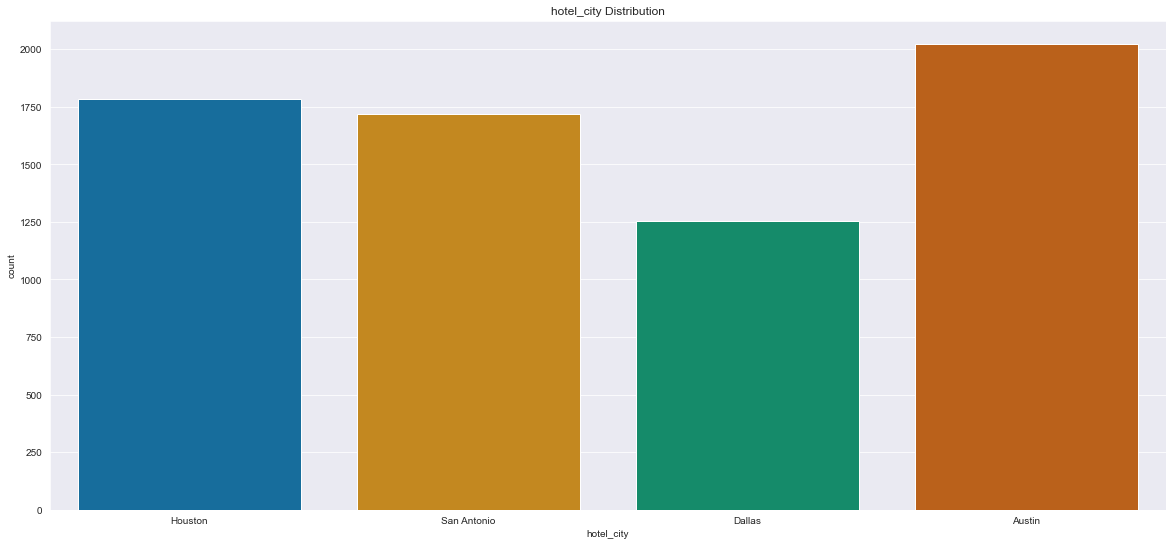

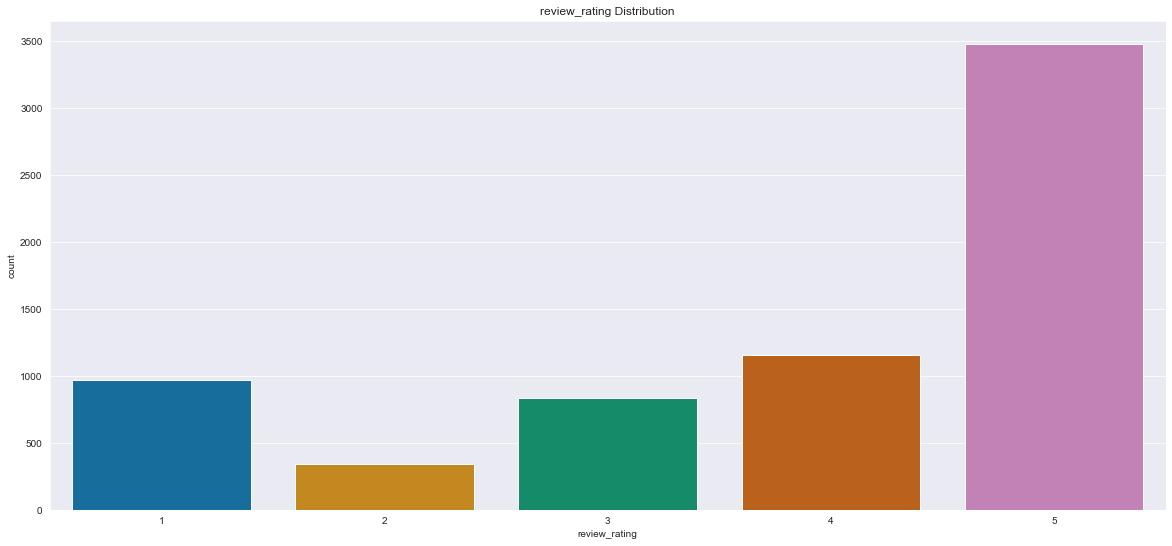

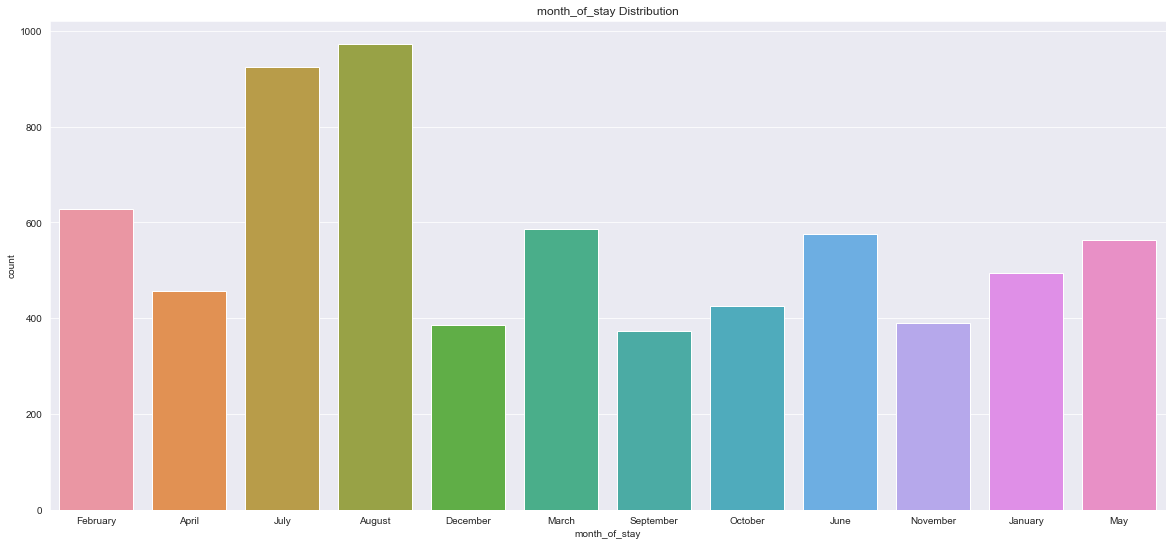

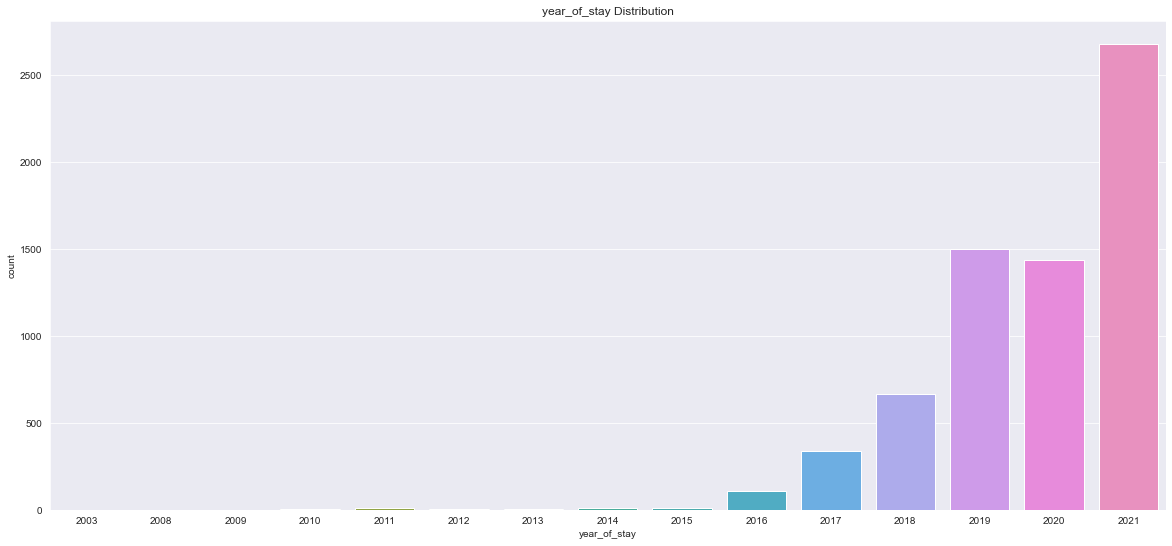

In [16]:
explore.get_distribution(train.drop(columns=['hotel_name','review', 'review_cleaned','positive_sentiment','negative_sentiment', 'neutral_sentiment','message_length', 'word_count']))

### Bivariate

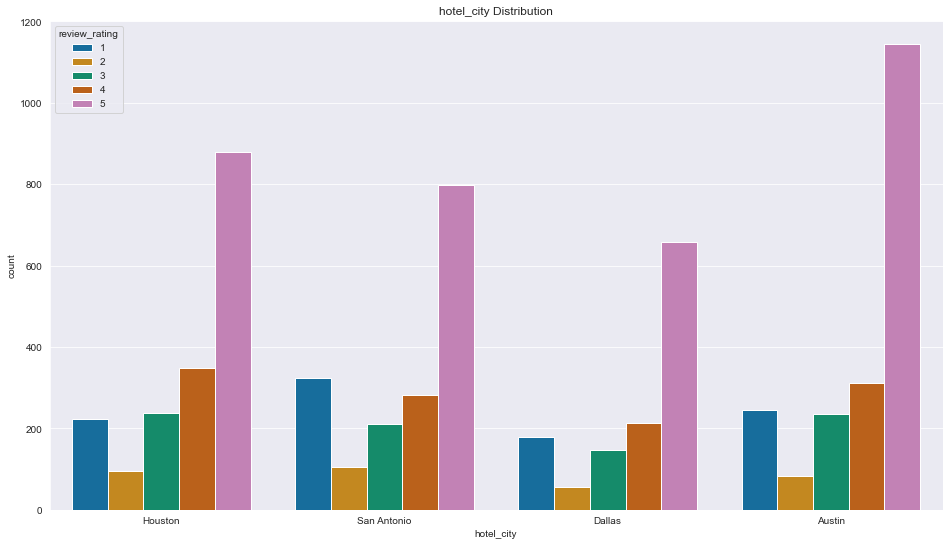

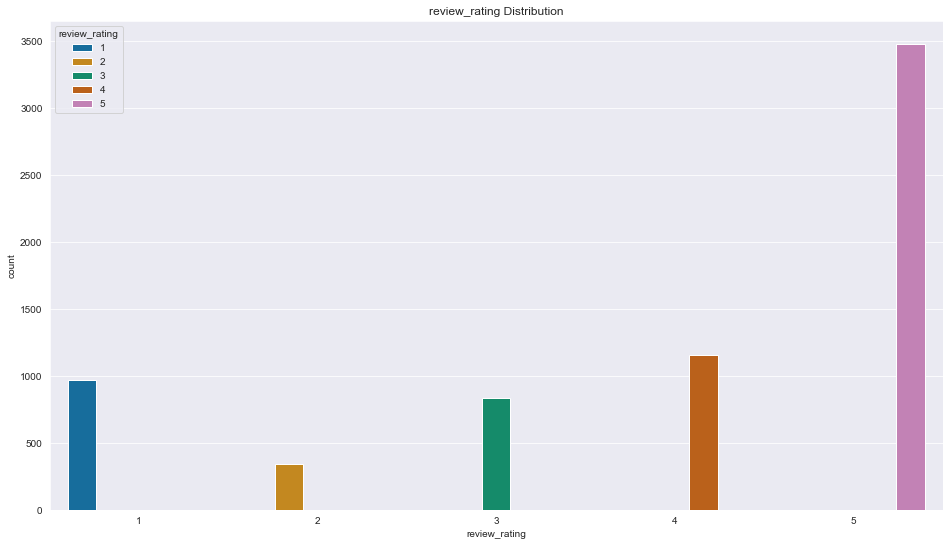

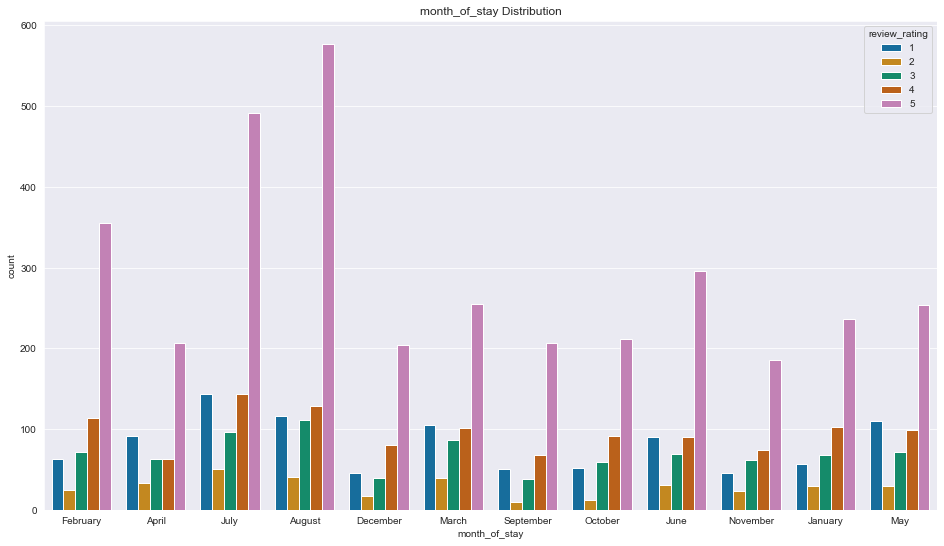

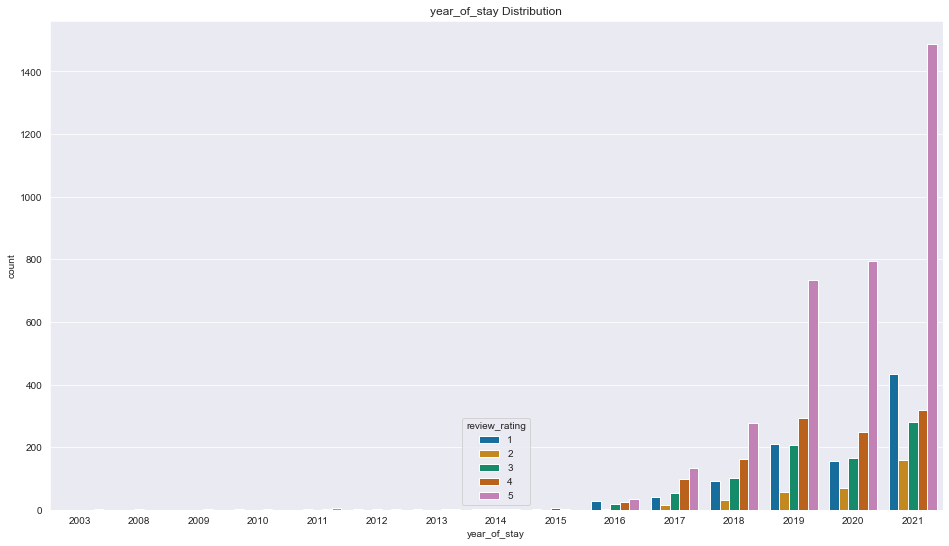

In [17]:
explore.compare_to_target(train.drop(columns=['hotel_name','review', 'review_cleaned','positive_sentiment','negative_sentiment', 'neutral_sentiment','word_count', 'message_length']), 'review_rating')

### Does word count and message length differ for different review ratings?

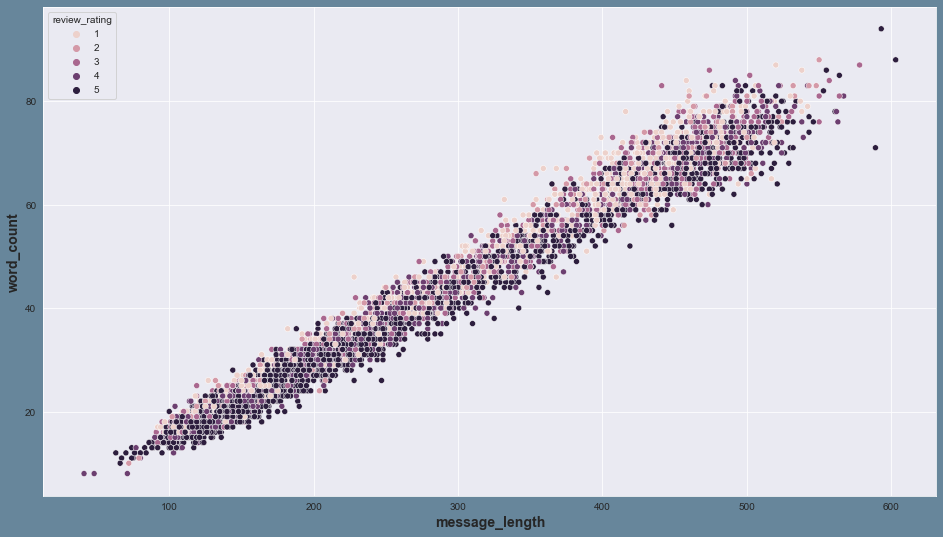

In [18]:
plt.figure(figsize=(16,9),facecolor='#67869b') 
sns.scatterplot(data = train, x = 'message_length', y ='word_count', hue='review_rating')
plt.xlabel('message_length',fontweight='bold', fontsize=14)
plt.ylabel('word_count',fontweight='bold', fontsize=14)
plt.show()

### Average Message length for each review score?

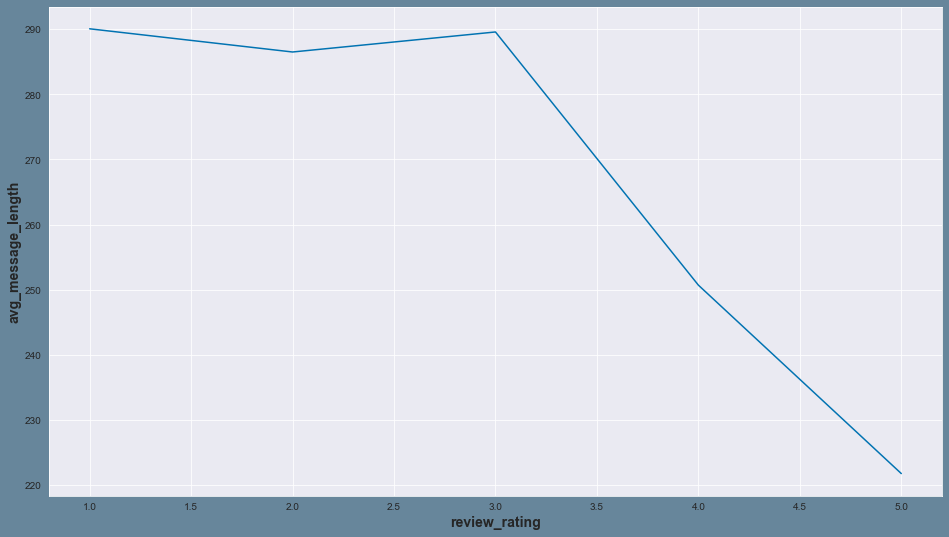

In [19]:
plt.figure(figsize=(16,9),facecolor='#67869b') 
group = train.groupby(['review_rating']).agg(avg_message_length =("message_length", 'mean'))
group = group.reset_index()
plt.xlabel('review_rating',fontweight='bold', fontsize=14)
plt.ylabel('avg_message_length',fontweight='bold', fontsize=14) 
sns.lineplot(data=group, x = 'review_rating', y = 'avg_message_length')
plt.show()

### Average Word Count for each review score?

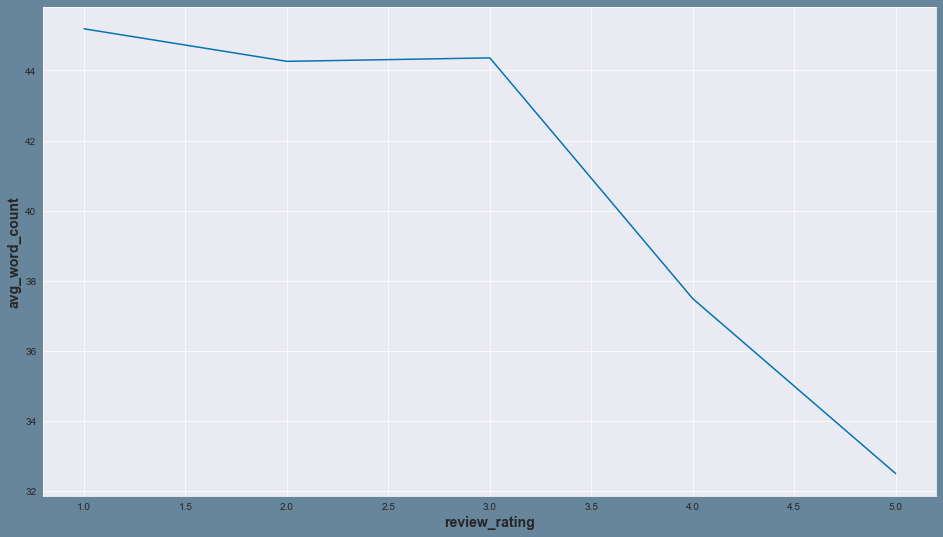

In [20]:
plt.figure(figsize=(16,9),facecolor='#67869b') 
group = train.groupby(['review_rating']).agg(avg_word_count =("word_count", 'mean'))
group = group.reset_index()
sns.lineplot(data=group, x = 'review_rating', y = 'avg_word_count')
plt.xlabel('review_rating',fontweight='bold', fontsize=14)
plt.ylabel('avg_word_count',fontweight='bold', fontsize=14) 
plt.show()

### Average rating for each city?

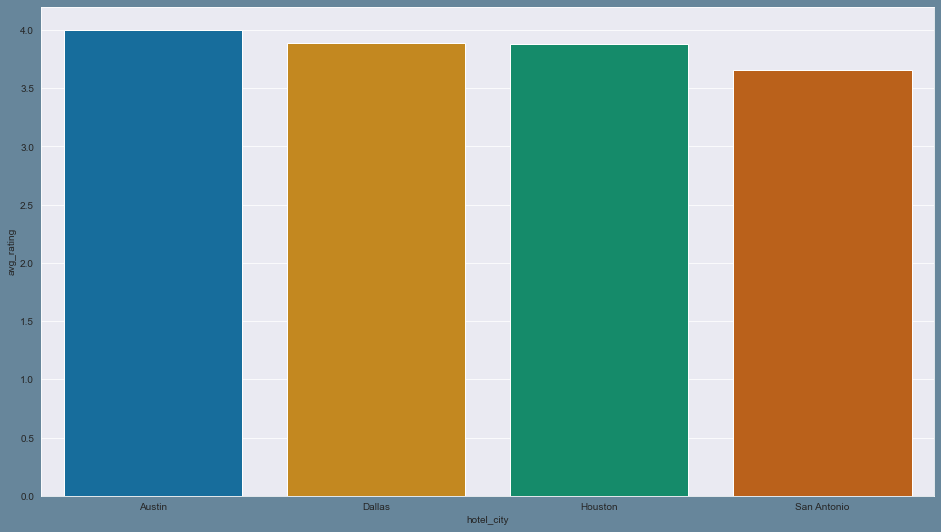

In [21]:
plt.figure(figsize=(16,9),facecolor='#67869b') 
group = train.groupby(['hotel_city']).agg(avg_rating =("review_rating", 'mean'))
group = group.reset_index()
sns.barplot(data=group, x = 'hotel_city', y = 'avg_rating')
plt.show()

### Average Rating for each month? 

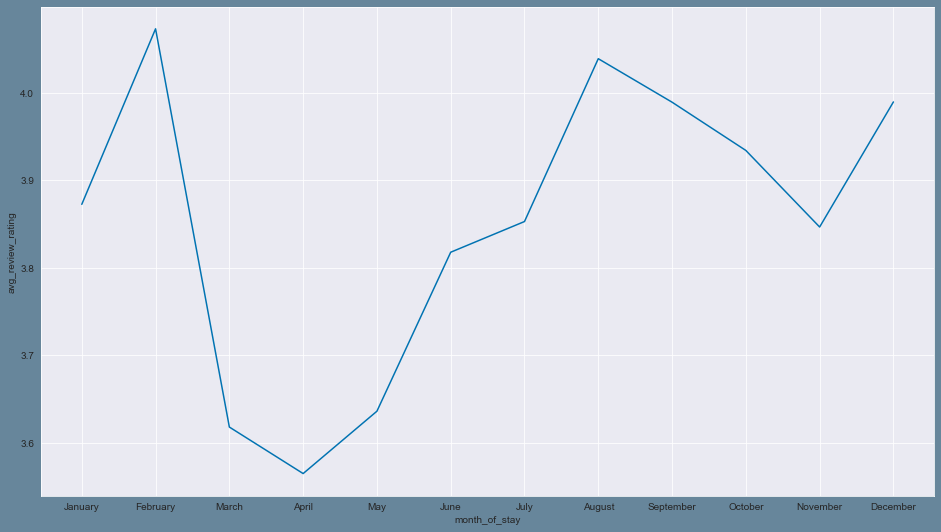

In [82]:
plt.figure(figsize=(16,9),facecolor='#67869b')
months = ['January','February','March', 'April','May','June','July','August','September','October','November','December']
train['month_of_stay'] = pd.CategoricalIndex(train['month_of_stay'], categories=months, ordered=True)
group = train.groupby(['month_of_stay']).agg(avg_review_rating =("review_rating", 'mean'))
group = group.reset_index()
sns.lineplot(data=group, x = 'month_of_stay', y = 'avg_review_rating')
plt.show()

### Average Sentiment for each review rating?

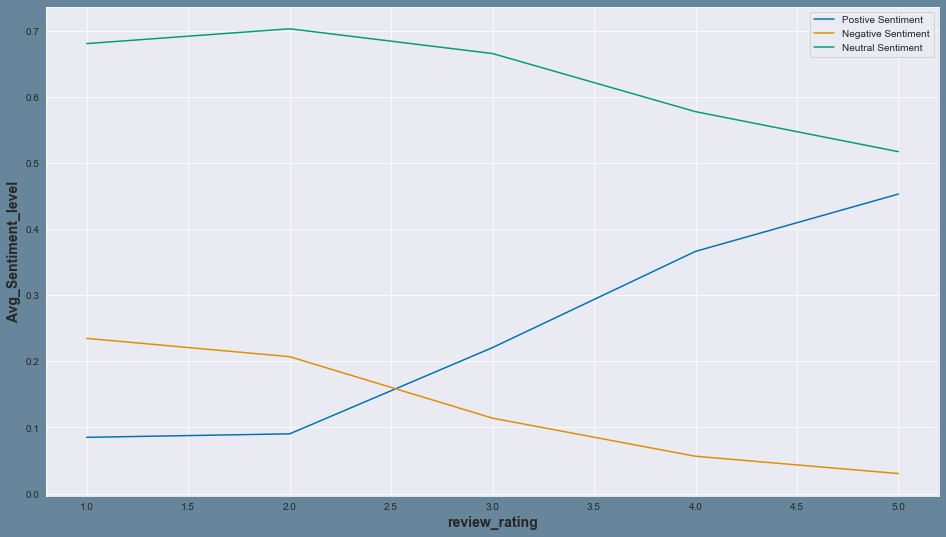

In [23]:
plt.figure(figsize=(16,9),facecolor='#67869b') 
group = train.groupby(['review_rating']).agg(avg_pos_sent =("positive_sentiment", 'mean'), avg_neg_sent =('negative_sentiment', 'mean'), avg_neu_sent =('neutral_sentiment', 'mean'))
group = group.reset_index()
sns.lineplot(data=group, x = 'review_rating', y = 'avg_pos_sent')
sns.lineplot(data=group, x = 'review_rating', y = 'avg_neg_sent')
sns.lineplot(data=group, x = 'review_rating', y = 'avg_neu_sent')
plt.xlabel('review_rating',fontweight='bold', fontsize=14)
plt.ylabel('Avg_Sentiment_level',fontweight='bold', fontsize=14) 
plt.legend(labels=['Postive Sentiment','Negative Sentiment','Neutral Sentiment'])
plt.show()

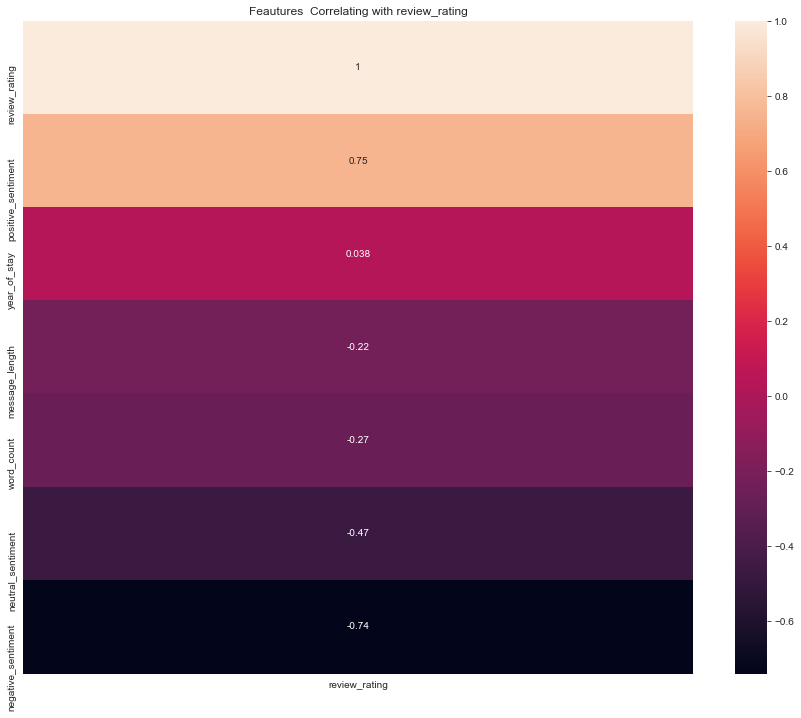

<AxesSubplot:title={'center':'Feautures  Correlating with review_rating'}>

In [24]:
explore.get_heatmap(train, 'review_rating')

#### Takeaways 

- Univariate
    * When selecting reviews at random, theyre were more 5 star reviews, followed by one star reviews. Hinting may tend to be obligated to write a review  when they either really loved their stay , or despised it.
    * When collecting reviews at random, many of the hotel stays took place in Auguest, followed by July and May. Mid-summer and spring break time seem to be the most popular times to visit hotels, while the least month of stay was september and november.
- Bivariate, in relation to review rating
    * Hotel Ratings for each city were still distributed in order as follows: 5,1,4,3,2 
    * The distrubution differs over the various months 
- Multivariate
    * Word count and message length decrease on average as the review gets better. suggesting when bad reviews have more words on average.
    * Austin and Houston have the best reviews on average, while San Antonio had the worst reviews on average
    * In terms of sentiment, Negative sentiment decreases as review ratings get higher, Positive sentiment increases as reviews get higher, Neatural sentiment is higher in negative reviews then positive sentiment.
    

## Explore - Word Analysis 

In [25]:
#Split words into strings 

In [26]:
one_read = ' '.join(train[train.review_rating == 1].review_cleaned)
two_read = ' '.join(train[train.review_rating == 2].review_cleaned)
three_read = ' '.join(train[train.review_rating == 3].review_cleaned)
four_read = ' '.join(train[train.review_rating == 4].review_cleaned)
five_read = ' '.join(train[train.review_rating == 5].review_cleaned)
all_read = ' '.join(train.review_cleaned)

In [27]:
#creating word frequencies
one_freq = pd.Series(one_read.split()).value_counts()
two_freq = pd.Series(two_read.split()).value_counts()
three_freq= pd.Series(three_read.split()).value_counts()
four_freq= pd.Series(four_read.split()).value_counts()
five_freq = pd.Series(five_read.split()).value_counts()
all_freq = pd.Series(all_read.split()).value_counts()

In [28]:
#create word list
one_star_words = re.sub(r'[^\w\s]', '', one_read).split()
two_star_words = re.sub(r'[^\w\s]', '', two_read).split()
three_star_words = re.sub(r'[^\w\s]', '', three_read).split()
four_star_words = re.sub(r'[^\w\s]', '', four_read).split()
five_star_words = re.sub(r'[^\w\s]', '', five_read).split()
all_words = re.sub(r'[^\w\s]', '', all_read).split()

In [29]:
#Creating word counts table
word_table = (pd.concat([one_freq, two_freq, three_freq, four_freq, five_freq,  all_freq], axis=1, sort=True)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
#naming the columns
word_table.columns = ['one', 'two', 'three', 'four', 'five', 'All']

In [30]:
def show_distributions(word_table, orderby=None):
    plt.rc('figure', figsize=(16,9))
    (word_table
 .assign(one = word_table[orderby]  )
 .sort_values(orderby)
 [[orderby]]
 .tail(20)
 .sort_values(orderby)
 .plot.barh(stacked=True))
    

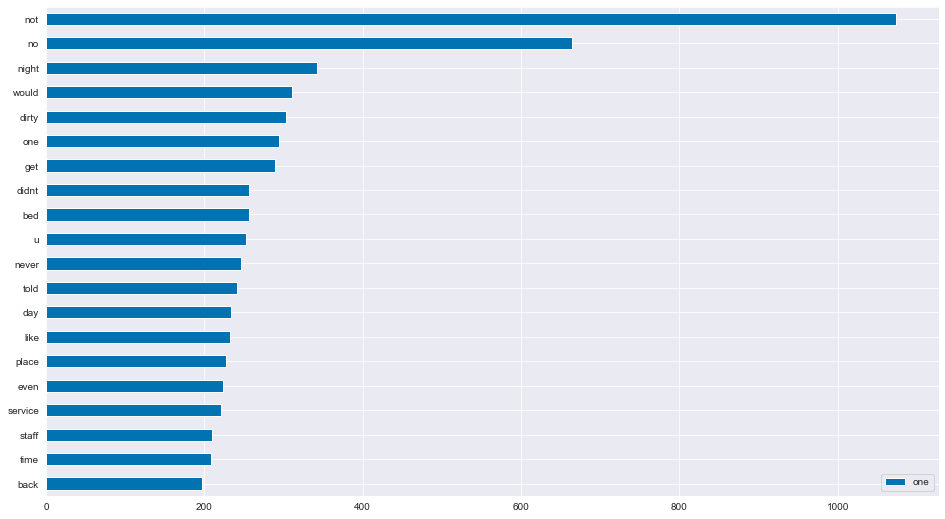

In [31]:
show_distributions(word_table, 'one')

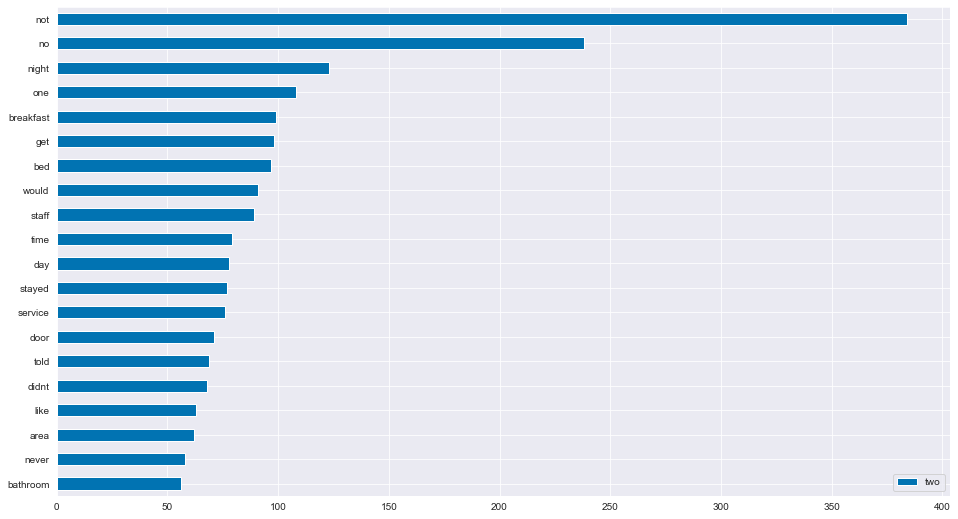

In [32]:
show_distributions(word_table, 'two')

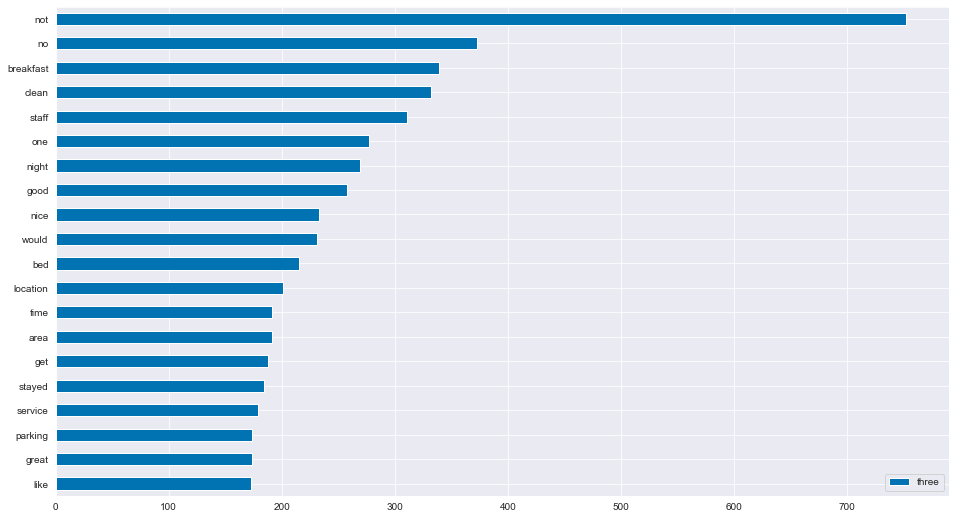

In [33]:
show_distributions(word_table, 'three')

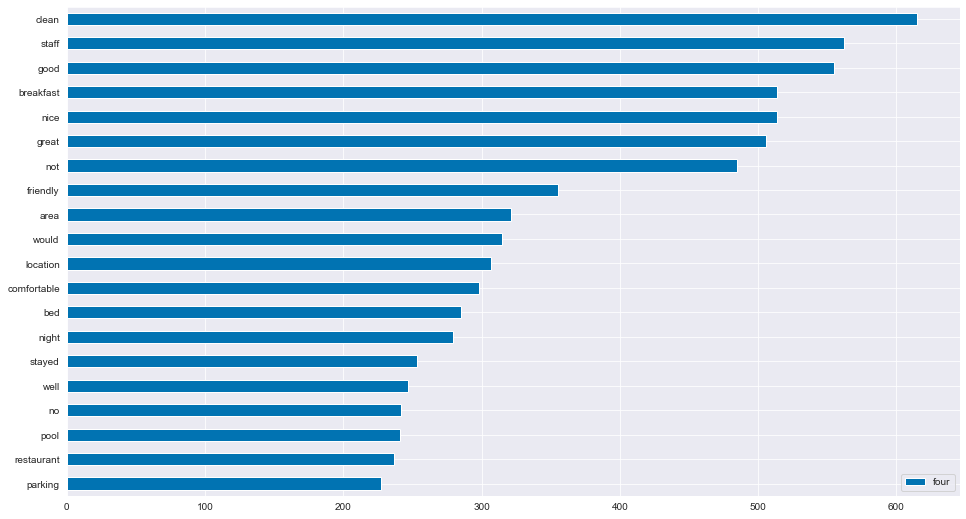

In [34]:
show_distributions(word_table, 'four')

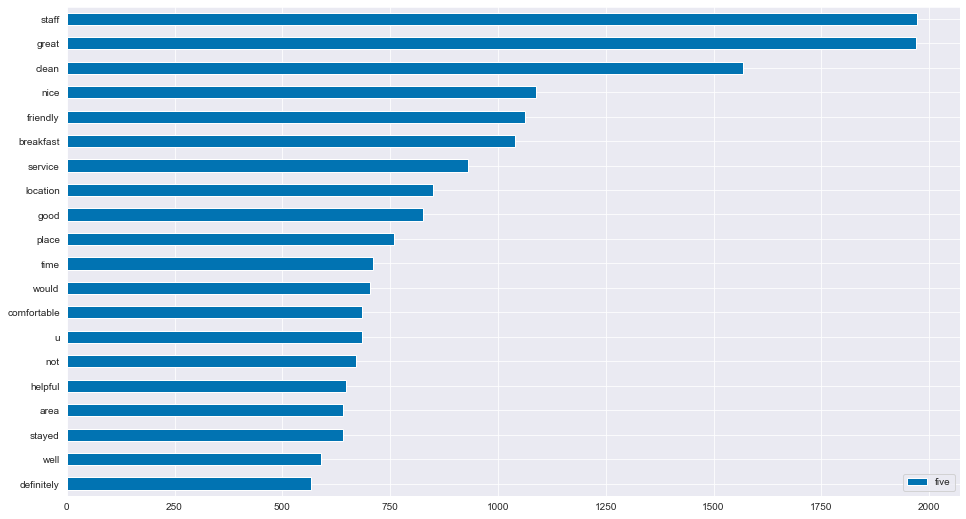

In [35]:
show_distributions(word_table, 'five')

In [36]:
from wordcloud import WordCloud
#function to create word clouds
def word_cloud(word_string, name):
    img = WordCloud(background_color='white', width=800, height=600).generate(word_string)
    print('-------------------')
    print(f'{name}')
    print('-------------------')
    plt.imshow(img)
    plt.axis('off')


def df_to_wordcloud(df, star = None):
    if star: 
        df = df[df.review_rating == star]
    else:
        star = 'all_words'
    to_list = ''
    for readme in df.review_cleaned:
        to_list += readme
    word_cloud(to_list,star)
    
    
def bigrams_wordclouds(thelist):
    data = {k[0] + ' ' + k[1]: v for k, v in thelist.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(16,9))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def trigrams_wordclouds(thelist):
    data = {k[0] + ' ' + k[1] + ' '+ k[2]: v for k, v in thelist.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(16,9))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

-------------------
1
-------------------


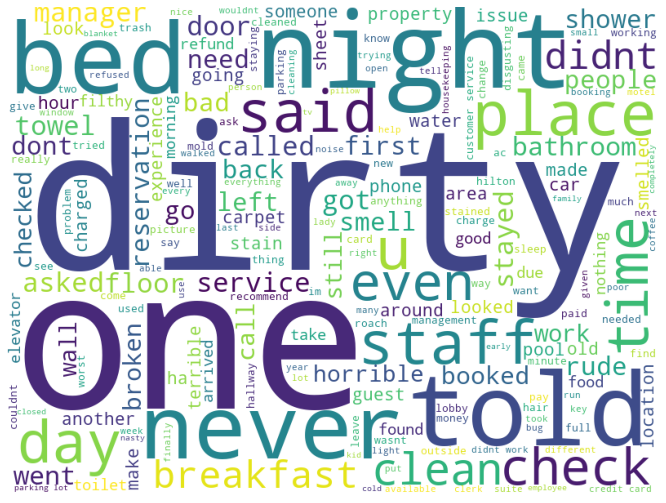

In [37]:
df_to_wordcloud(train, 1)

-------------------
2
-------------------


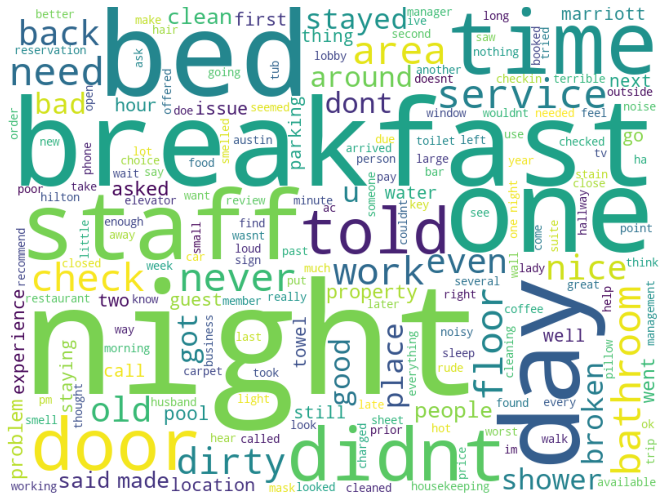

In [38]:
df_to_wordcloud(train, 2)

-------------------
3
-------------------


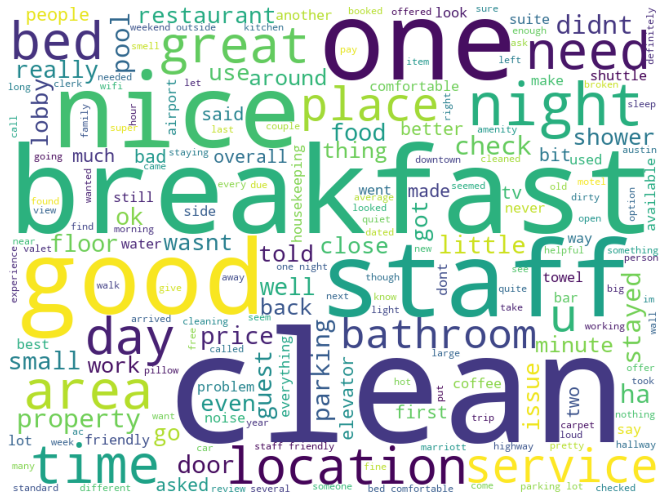

In [39]:
df_to_wordcloud(train, 3)

-------------------
4
-------------------


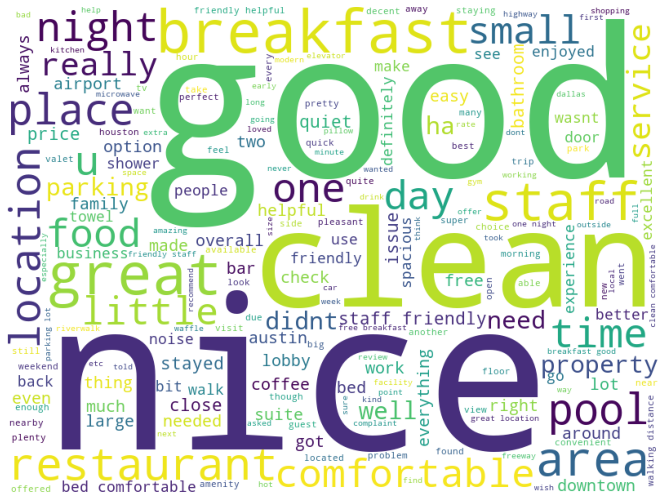

In [40]:
df_to_wordcloud(train, 4)

-------------------
5
-------------------


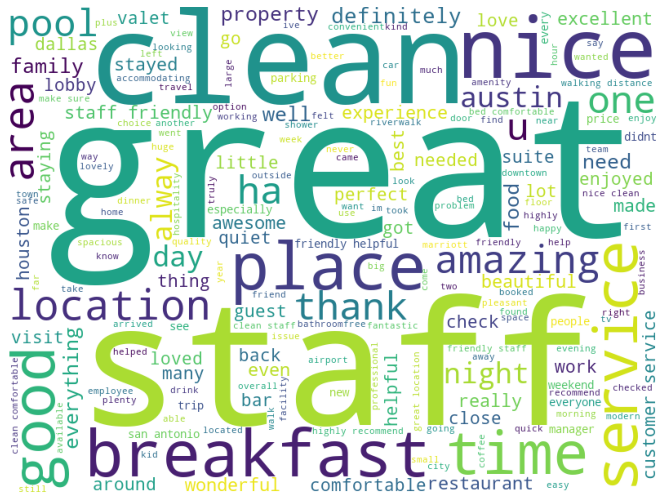

In [41]:
df_to_wordcloud(train, 5)

In [42]:
#bigrams
#bigrams for each review type
bigrams_one = pd.Series(nltk.ngrams(one_read.split(), 2)).value_counts()
bigrams_two = pd.Series(nltk.ngrams(two_read.split(), 2)).value_counts()
bigrams_three = pd.Series(nltk.ngrams(three_read.split(), 2)).value_counts()
bigrams_four = pd.Series(nltk.ngrams(four_read.split(), 2)).value_counts()
bigrams_five = pd.Series(nltk.ngrams(five_read.split(), 2)).value_counts()

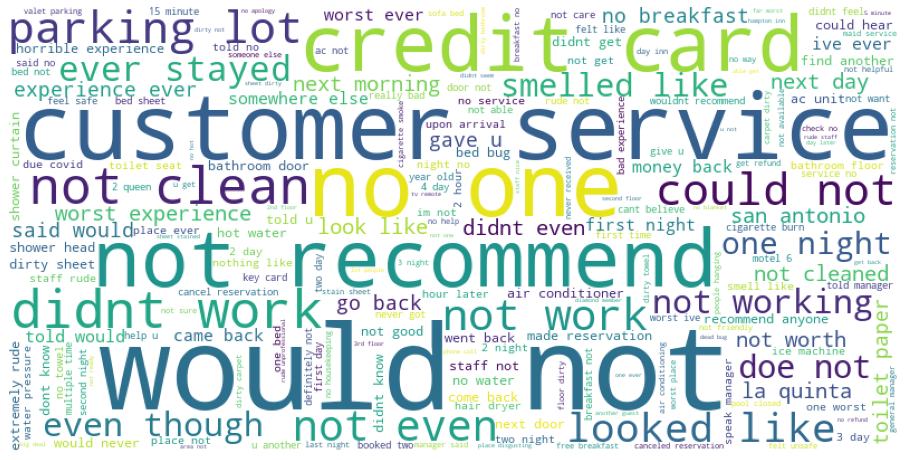

In [43]:
bigrams_wordclouds(bigrams_one)

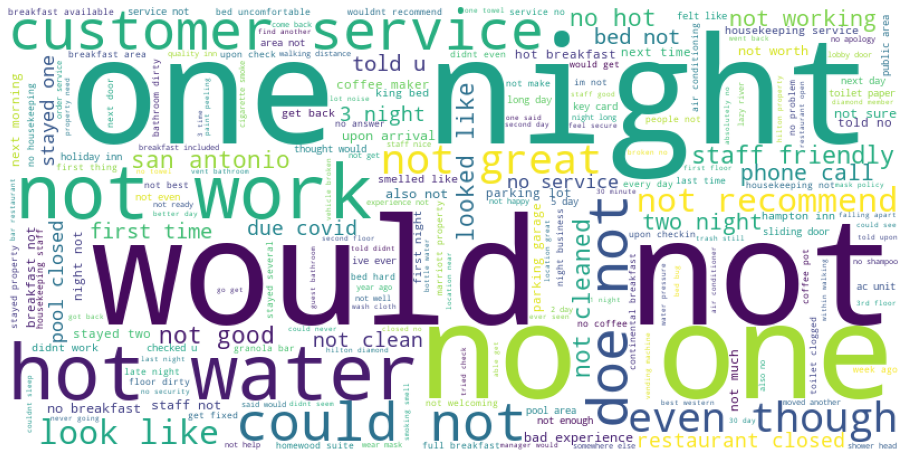

In [44]:
bigrams_wordclouds(bigrams_two)

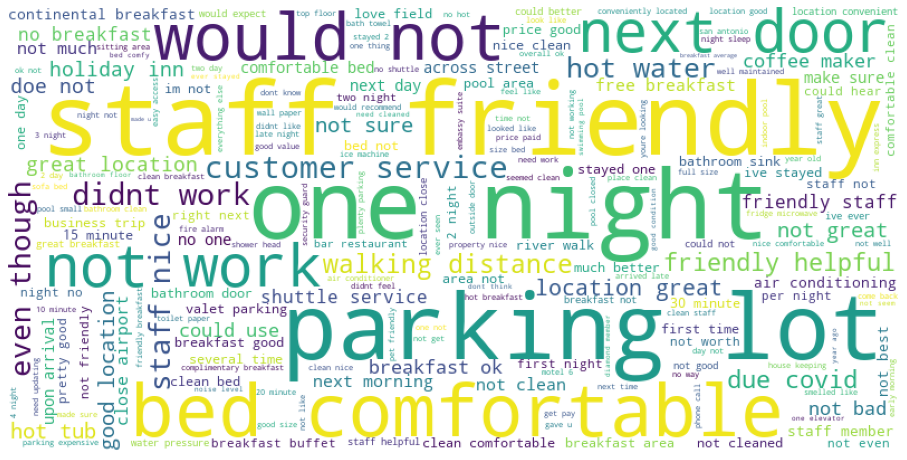

In [45]:
bigrams_wordclouds(bigrams_three)

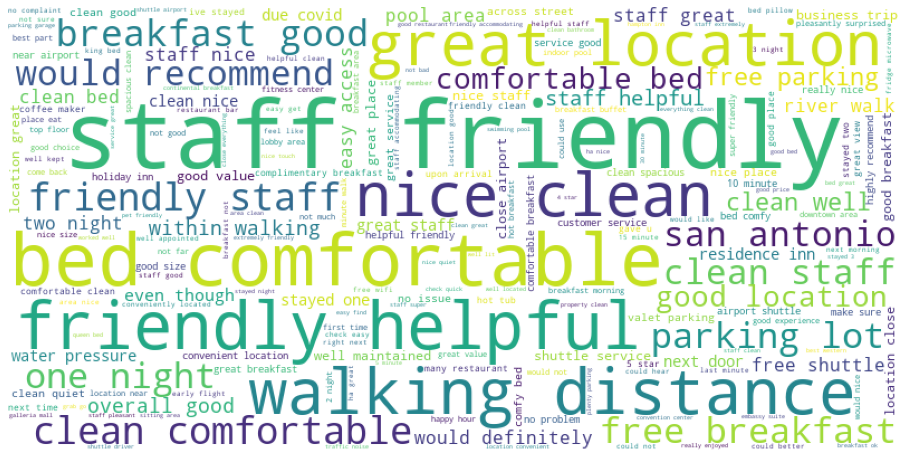

In [46]:
bigrams_wordclouds(bigrams_four)

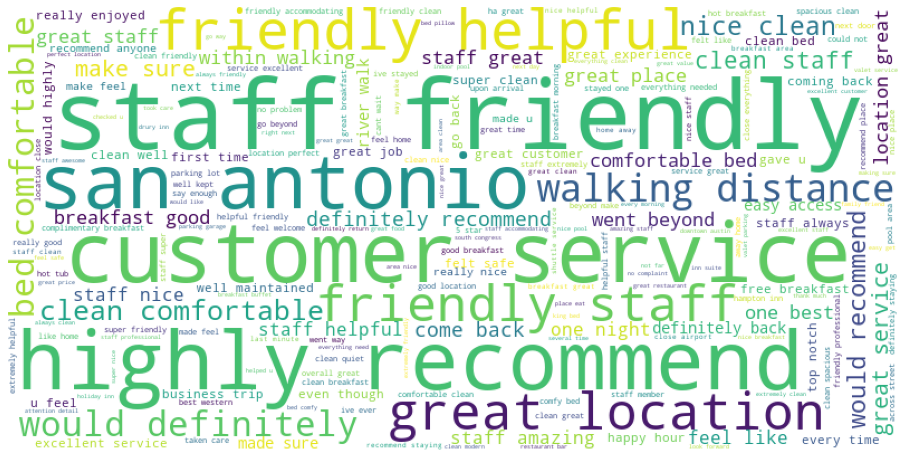

In [47]:
bigrams_wordclouds(bigrams_five)

In [48]:
#trigrams
#trigrams for each review type
trigrams_one = pd.Series(nltk.ngrams(one_read.split(), 3)).value_counts()
trigrams_two = pd.Series(nltk.ngrams(two_read.split(), 3)).value_counts()
trigrams_three = pd.Series(nltk.ngrams(three_read.split(), 3)).value_counts()
trigrams_four = pd.Series(nltk.ngrams(four_read.split(), 3)).value_counts()
trigrams_five = pd.Series(nltk.ngrams(five_read.split(), 3)).value_counts()

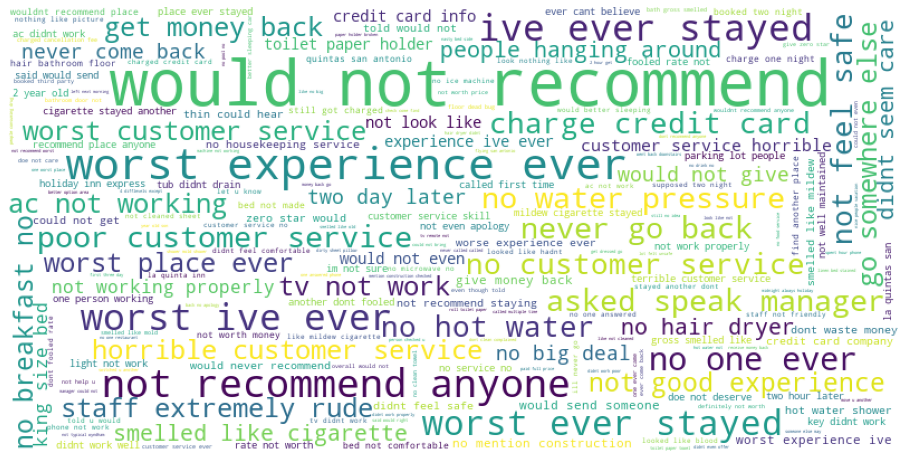

In [49]:
trigrams_wordclouds(trigrams_one)

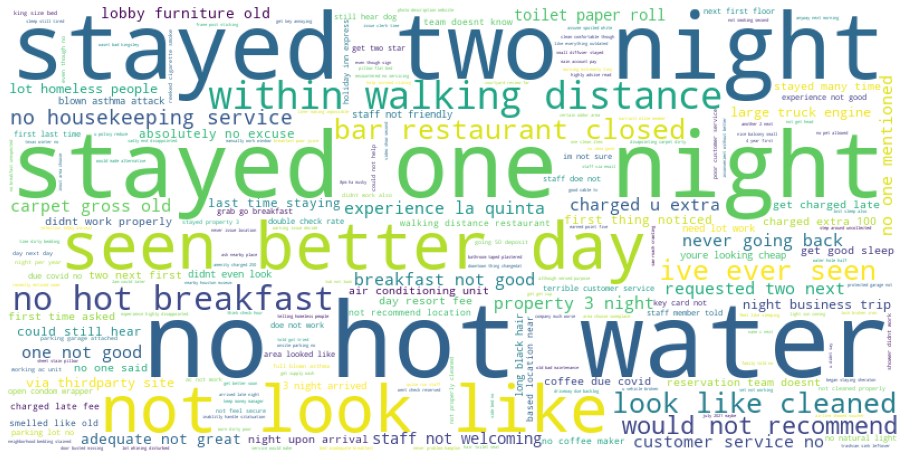

In [50]:
trigrams_wordclouds(trigrams_two)

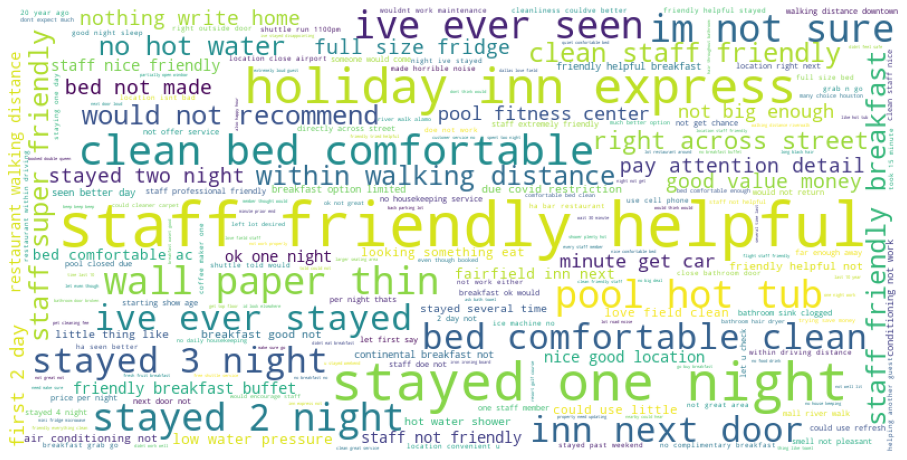

In [51]:
trigrams_wordclouds(trigrams_three)

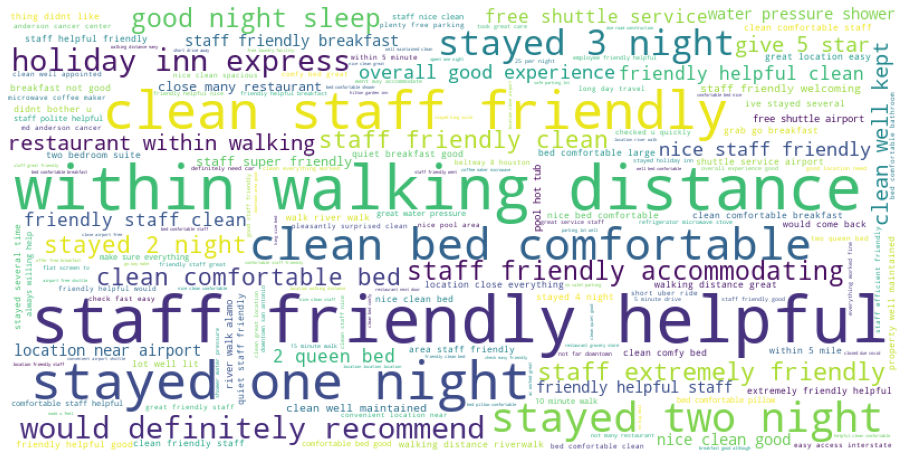

In [52]:
trigrams_wordclouds(trigrams_four)

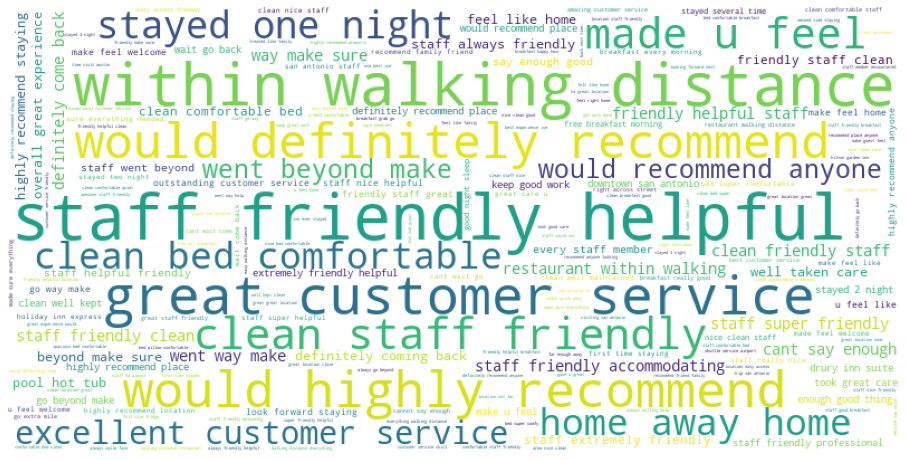

In [53]:
trigrams_wordclouds(trigrams_five)

## Takeaways

In [54]:
#remove top 3 most common words that are not negative (room, hotel)
top = all_freq.head(30).index.to_list()

# Statistical Testing 
- Testing positive, negative and neutral sentiment of the words, as well as the message length and word count to see if that correlates to the review rating given by the hotel guest

In [55]:
target = 'review_rating'
con_vars = ['positive_sentiment', 'negative_sentiment','neutral_sentiment','message_length', 'word_count']
evaluate.get_t_test(con_vars,train, 1, target,  0.05, var2=5)

Null Hypothesis: the mean value of positive_sentiment is the same when review_rating == 1 and 5
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of negative_sentiment is the same when review_rating == 1 and 5
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of neutral_sentiment is the same when review_rating == 1 and 5
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 1.917777328020427e-219 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of message_length is the same when review_rating == 1 and 5
Alternative hypothesis: the mean value of {}

In [56]:
evaluate.get_t_test(con_vars,train, 2, target,  0.05, var2=4)

Null Hypothesis: the mean value of positive_sentiment is the same when review_rating == 2 and 4
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of negative_sentiment is the same when review_rating == 2 and 4
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 4.913145257090885e-111 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of neutral_sentiment is the same when review_rating == 2 and 4
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 2.4581450549849125e-56 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of message_length is the same when review_rating == 2 and 4
Alternative hypothesis: t

In [57]:
evaluate.get_t_test(con_vars,train, 4, target,  0.05, var2=5)

Null Hypothesis: the mean value of positive_sentiment is the same when review_rating == 4 and 5
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 8.646406239888815e-76 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of negative_sentiment is the same when review_rating == 4 and 5
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 3.384418815420946e-42 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of neutral_sentiment is the same when review_rating == 4 and 5
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 1.7101339200837284e-43 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of message_length is the same when review_rating == 4 and 5
Alternat

### Using a 2 tailed t test, we can see clear correlation to the factors when review rating

In [58]:
evaluate.get_t_test(con_vars,train, 1, target,  0.05, var2=2)

Null Hypothesis: the mean value of positive_sentiment is the same when review_rating == 1 and 2
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 0.1572471070587573 is not less than alpha 0.05 , we  fail to reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of negative_sentiment is the same when review_rating == 1 and 2
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 1.1557228820656296e-06 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of neutral_sentiment is the same when review_rating == 1 and 2
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 0.001963418906236171 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of message_length is the same when review_rating == 1 and 2

In [59]:
evaluate.get_t_test(con_vars,train, 1, target,  0.05, var2=3)

Null Hypothesis: the mean value of positive_sentiment is the same when review_rating == 1 and 3
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 1.2761792431209715e-142 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of negative_sentiment is the same when review_rating == 1 and 3
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 2.973498867018326e-137 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of neutral_sentiment is the same when review_rating == 1 and 3
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 0.007233231448456164 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of message_length is the same when review_rating == 1 and 3
Alterna

In [60]:
evaluate.get_t_test(con_vars,train, 2, target,  0.05, var2=3)

Null Hypothesis: the mean value of positive_sentiment is the same when review_rating == 2 and 3
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 1.9014069525613114e-107 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of negative_sentiment is the same when review_rating == 2 and 3
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 1.3836780547842923e-53 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of neutral_sentiment is the same when review_rating == 2 and 3
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 4.389429731798186e-07 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of message_length is the same when review_rating == 2 and 3
Altern

In [61]:
evaluate.get_t_test(con_vars,train, 3, target,  0.05, var2=4)

Null Hypothesis: the mean value of positive_sentiment is the same when review_rating == 3 and 4
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 2.8568337633755655e-123 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of negative_sentiment is the same when review_rating == 3 and 4
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 1.5549517342018307e-57 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of neutral_sentiment is the same when review_rating == 3 and 4
Alternative hypothesis: the mean value of {} is not the same when {} == {} and {}
p value 4.6753220467046106e-54 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: the mean value of message_length is the same when review_rating == 3 and 4
Alter

In [62]:
evaluate.get_t_test(con_vars,train, 1, target,  0.05,tail_type=1)

Null Hypothesis: for positive_sentiment, the review_rating mean when review_rating == 1 is the same as the population mean
Alternative hypothesis: for positive_sentiment, the review_rating mean when review_rating == 1 is not the same as the population mean
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: for negative_sentiment, the review_rating mean when review_rating == 1 is the same as the population mean
Alternative hypothesis: for negative_sentiment, the review_rating mean when review_rating == 1 is not the same as the population mean
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: for neutral_sentiment, the review_rating mean when review_rating == 1 is the same as the population mean
Alternative hypothesis: for neutral_sentiment, the review_rating mean when review_rating == 1 is not the same as the population mean
p value 0.0 is less tha

In [63]:
evaluate.get_t_test(con_vars,train, 2, target,  0.05,tail_type=1)

Null Hypothesis: for positive_sentiment, the review_rating mean when review_rating == 2 is the same as the population mean
Alternative hypothesis: for positive_sentiment, the review_rating mean when review_rating == 2 is not the same as the population mean
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: for negative_sentiment, the review_rating mean when review_rating == 2 is the same as the population mean
Alternative hypothesis: for negative_sentiment, the review_rating mean when review_rating == 2 is not the same as the population mean
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: for neutral_sentiment, the review_rating mean when review_rating == 2 is the same as the population mean
Alternative hypothesis: for neutral_sentiment, the review_rating mean when review_rating == 2 is not the same as the population mean
p value 0.0 is less tha

In [64]:
evaluate.get_t_test(con_vars,train, 3, target,  0.05,tail_type=1)

Null Hypothesis: for positive_sentiment, the review_rating mean when review_rating == 3 is the same as the population mean
Alternative hypothesis: for positive_sentiment, the review_rating mean when review_rating == 3 is not the same as the population mean
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: for negative_sentiment, the review_rating mean when review_rating == 3 is the same as the population mean
Alternative hypothesis: for negative_sentiment, the review_rating mean when review_rating == 3 is not the same as the population mean
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: for neutral_sentiment, the review_rating mean when review_rating == 3 is the same as the population mean
Alternative hypothesis: for neutral_sentiment, the review_rating mean when review_rating == 3 is not the same as the population mean
p value 0.0 is less tha

In [65]:
evaluate.get_t_test(con_vars,train, 4, target,  0.05,tail_type=1)

Null Hypothesis: for positive_sentiment, the review_rating mean when review_rating == 4 is the same as the population mean
Alternative hypothesis: for positive_sentiment, the review_rating mean when review_rating == 4 is not the same as the population mean
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: for negative_sentiment, the review_rating mean when review_rating == 4 is the same as the population mean
Alternative hypothesis: for negative_sentiment, the review_rating mean when review_rating == 4 is not the same as the population mean
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: for neutral_sentiment, the review_rating mean when review_rating == 4 is the same as the population mean
Alternative hypothesis: for neutral_sentiment, the review_rating mean when review_rating == 4 is not the same as the population mean
p value 0.0 is less tha

In [66]:
evaluate.get_t_test(con_vars,train, 5, target,  0.05,tail_type=1)

Null Hypothesis: for positive_sentiment, the review_rating mean when review_rating == 5 is the same as the population mean
Alternative hypothesis: for positive_sentiment, the review_rating mean when review_rating == 5 is not the same as the population mean
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: for negative_sentiment, the review_rating mean when review_rating == 5 is the same as the population mean
Alternative hypothesis: for negative_sentiment, the review_rating mean when review_rating == 5 is not the same as the population mean
p value 0.0 is less than alpha 0.05 , we reject our null hypothesis
-----------------------------------
Null Hypothesis: for neutral_sentiment, the review_rating mean when review_rating == 5 is the same as the population mean
Alternative hypothesis: for neutral_sentiment, the review_rating mean when review_rating == 5 is not the same as the population mean
p value 0.0 is less tha

# Modeling 

In [67]:
#modeling for words
tfidf = TfidfVectorizer(ngram_range=(1,3))
X = tfidfs = tfidf.fit_transform(df.review_cleaned)
y = df.review_rating

In [68]:
#modeling for sentiment and word length
X2 = df[['negative_sentiment']]

In [69]:
X_train, X_validate, y_train, y_validate, X_test, y_test = modeling.xy_split(X, y)

In [70]:
X_train2,X_validate2, y_train2, y_validate2, X_test2, y_test2 = modeling.xy_split(X2,y)

In [71]:
modeling.get_baseline(train)

51.32800%


In [72]:
tree = DecisionTreeClassifier(max_depth=6)
modeling.train_validate_results(tree, X_train, y_train, X_validate, y_validate, details=True)

Train model Accuracy: 62.92798 %  | Validate model accuracy: 58.57438 % 
Train model Recall: 62.92798 %    | Validate model Recall: 35.55352 %
Train model Precision: 62.92798 % | Validate model Precision: 33.76597 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                    1           2           3            4            5  \
precision    0.500672    0.555556    0.434343     0.626168     0.687085   
recall       0.768041    0.014749    0.206235     0.116017     0.922369   
f1-score     0.606184    0.028736    0.279675     0.195763     0.787529   
support    970.000000  339.000000  834.000000  1155.000000  3478.000000   

           accuracy    macro avg  weighted avg  
precision   0.62928     0.560765      0.612328  
recall      0.62928     0.405482      0.629280  
f1-score    0.62928     0.379577      0.560230  
support     0.62928  6776.000000   6776.000000  
------Validate C

In [73]:
rf = RandomForestClassifier(max_depth=8, random_state=20)
modeling.train_validate_results(rf, X_train, y_train, X_validate, y_validate, details=True)

Train model Accuracy: 51.32822 %  | Validate model accuracy: 51.34298 % 
Train model Recall: 51.32822 %    | Validate model Recall: 20.00000 %
Train model Precision: 51.32822 % | Validate model Precision: 10.26860 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
               1      2      3       4            5  accuracy    macro avg  \
precision    0.0    0.0    0.0     0.0     0.513282  0.513282     0.102656   
recall       0.0    0.0    0.0     0.0     1.000000  0.513282     0.200000   
f1-score     0.0    0.0    0.0     0.0     0.678369  0.513282     0.135674   
support    970.0  339.0  834.0  1155.0  3478.000000  0.513282  6776.000000   

           weighted avg  
precision      0.263459  
recall         0.513282  
f1-score       0.348195  
support     6776.000000  
------Validate Classification report-----
               1      2      3      4            5  accuracy    macro avg 

In [74]:
nb = MultinomialNB(alpha=1.0)
modeling.train_validate_results(nb, X_train, y_train, X_validate, y_validate, details=True)

Train model Accuracy: 53.73377 %  | Validate model accuracy: 51.41185 % 
Train model Recall: 53.73377 %    | Validate model Recall: 20.09639 %
Train model Precision: 53.73377 % | Validate model Precision: 30.27567 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                    1      2      3       4            5  accuracy  \
precision    1.000000    0.0    0.0     0.0     0.525934  0.537338   
recall       0.168041    0.0    0.0     0.0     1.000000  0.537338   
f1-score     0.287732    0.0    0.0     0.0     0.689327  0.537338   
support    970.000000  339.0  834.0  1155.0  3478.000000  0.537338   

             macro avg  weighted avg  
precision     0.305187      0.413105  
recall        0.233608      0.537338  
f1-score      0.195412      0.395009  
support    6776.000000   6776.000000  
------Validate Classification report-----
                    1      2      3      4       

In [75]:
knn = KNeighborsClassifier(n_neighbors=15)
modeling.train_validate_results(knn, X_train, y_train, X_validate, y_validate, details=True)

Train model Accuracy: 67.82763 %  | Validate model accuracy: 64.22176 % 
Train model Recall: 67.82763 %    | Validate model Recall: 40.03535 %
Train model Precision: 67.82763 % | Validate model Precision: 44.87593 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                    1           2           3            4            5  \
precision    0.661893    0.514286    0.602317     0.566038     0.694926   
recall       0.857732    0.053097    0.187050     0.155844     0.980449   
f1-score     0.747194    0.096257    0.285453     0.244399     0.813357   
support    970.000000  339.000000  834.000000  1155.000000  3478.000000   

           accuracy    macro avg  weighted avg  
precision  0.678276     0.607892      0.647792  
recall     0.678276     0.446834      0.678276  
f1-score   0.678276     0.437332      0.606053  
support    0.678276  6776.000000   6776.000000  
------Validate C

In [76]:
svc = LinearSVC(C=.042)
modeling.train_validate_results(svc, X_train, y_train, X_validate, y_validate, details=True)

Train model Accuracy: 59.40083 %  | Validate model accuracy: 55.44077 % 
Train model Recall: 59.40083 %    | Validate model Recall: 25.73494 %
Train model Precision: 59.40083 % | Validate model Precision: 26.39525 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                    1      2           3            4            5  accuracy  \
precision    0.901695    0.0    1.000000     1.000000     0.563604  0.594008   
recall       0.548454    0.0    0.013189     0.003463     1.000000  0.594008   
f1-score     0.682051    0.0    0.026036     0.006903     0.720904  0.594008   
support    970.000000  339.0  834.000000  1155.000000  3478.000000  0.594008   

             macro avg  weighted avg  
precision     0.693060      0.711904  
recall        0.313021      0.594008  
f1-score      0.287179      0.472045  
support    6776.000000   6776.000000  
------Validate Classification report-----

In [77]:
lr = LogisticRegression(C=0.25)
modeling.train_validate_results(lr, X_train, y_train, X_validate, y_validate, details=True)

Train model Accuracy: 56.49351 %  | Validate model accuracy: 53.85675 % 
Train model Recall: 56.49351 %    | Validate model Recall: 23.51807 %
Train model Precision: 56.49351 % | Validate model Precision: 27.75469 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                    1      2      3            4            5  accuracy  \
precision    0.938172    0.0    0.0     1.000000     0.543183  0.564935   
recall       0.359794    0.0    0.0     0.000866     1.000000  0.564935   
f1-score     0.520119    0.0    0.0     0.001730     0.703977  0.564935   
support    970.000000  339.0  834.0  1155.000000  3478.000000  0.564935   

             macro avg  weighted avg  
precision     0.496271      0.583562  
recall        0.272132      0.564935  
f1-score      0.245165      0.436090  
support    6776.000000   6776.000000  
------Validate Classification report-----
                    1   

In [78]:
lr = LogisticRegression(C=0.25)
modeling.train_validate_results(lr, X_train2, y_train2, X_validate2, y_validate2, details=True)

Train model Accuracy: 60.77332 %  | Validate model accuracy: 60.26171 % 
Train model Recall: 60.77332 %    | Validate model Recall: 33.42096 %
Train model Precision: 60.77332 % | Validate model Precision: 23.51452 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                    1      2      3       4            5  accuracy  \
precision    0.581260    0.0    0.0     0.0     0.613465  0.607733   
recall       0.722680    0.0    0.0     0.0     0.982461  0.607733   
f1-score     0.644301    0.0    0.0     0.0     0.755305  0.607733   
support    970.000000  339.0  834.0  1155.0  3478.000000  0.607733   

             macro avg  weighted avg  
precision     0.238945      0.398089  
recall        0.341028      0.607733  
f1-score      0.279921      0.479918  
support    6776.000000   6776.000000  
------Validate Classification report-----
                    1      2      3      4       

In [79]:
knn = KNeighborsClassifier(n_neighbors=15)
modeling.train_validate_results(knn, X_train2, y_train2, X_validate2, y_validate2, details=True)

Train model Accuracy: 62.29339 %  | Validate model accuracy: 59.53857 % 
Train model Recall: 62.29339 %    | Validate model Recall: 36.85296 %
Train model Precision: 62.29339 % | Validate model Precision: 35.46151 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                    1           2           3            4            5  \
precision    0.535259    0.250000    0.355615     0.349296     0.699557   
recall       0.821649    0.035398    0.159472     0.107359     0.907131   
f1-score     0.648231    0.062016    0.220199     0.164238     0.789935   
support    970.000000  339.000000  834.000000  1155.000000  3478.000000   

           accuracy    macro avg  weighted avg  
precision  0.622934     0.437945      0.551509  
recall     0.622934     0.406202      0.622934  
f1-score   0.622934     0.376924      0.556455  
support    0.622934  6776.000000   6776.000000  
------Validate C